**TIKTOK DATA ANALYSIS**

In [2]:
import pandas as pd
import json

# Step 1: Load TikTok JSON file
file_path = '../user_data_tiktok.json'  # Replace with your file path
with open(file_path, 'r') as file:
    data = json.load(file)

# Step 2: Navigate to 'Video Browsing History' and extract 'VideoList'
video_browsing_history = data.get('Activity', {}).get('Video Browsing History', {})

# Debug: Check the content of 'Video Browsing History'
print("Type of 'Video Browsing History':", type(video_browsing_history))
print("Keys in 'Video Browsing History':", video_browsing_history.keys())

# Extract the 'VideoList' key
video_list = video_browsing_history.get('VideoList', [])
print(f"Type of 'VideoList': {type(video_list)}")  # Expecting a list of dictionaries

# Step 3: Convert 'VideoList' to DataFrame
if isinstance(video_list, list):
    video_df = pd.DataFrame(video_list)
    print("DataFrame created successfully!")
else:
    print("Error: 'VideoList' is not in the expected format.")
    video_df = pd.DataFrame()

# Step 4: Verify DataFrame content
if not video_df.empty:
    print("Available columns in DataFrame:", video_df.columns.tolist())
    print(video_df.head())

    # Step 5: Process 'Date' column if it exists
    if 'Date' in video_df.columns:
        video_df['Date'] = pd.to_datetime(video_df['Date'], errors='coerce')
        print("Successfully converted 'Date' column to datetime.")
    else:
        print("Error: 'Date' column not found in the DataFrame.")
else:
    print("No video data found.")
    exit()

# Verify date range
print(f"Data available from: {video_df['Date'].min()} to {video_df['Date'].max()}")

# Step 1: Sort DataFrame by Date
video_df = video_df.sort_values(by='Date').reset_index(drop=True)

# Step 2: Calculate time differences in seconds between consecutive videos
video_df['time_diff_seconds'] = video_df['Date'].diff().dt.total_seconds()

# Step 3: Replace NaN values with 0 for the first row
video_df['time_diff_seconds'] = video_df['time_diff_seconds'].fillna(0)

# Step 4: Remove unrealistic time gaps (> 10 minutes)
video_df.loc[video_df['time_diff_seconds'] > 600, 'time_diff_seconds'] = 0

# Step 5: Group by day and calculate total watch time (in minutes)
video_df['day'] = video_df['Date'].dt.date
daily_watch_time = video_df.groupby('day')['time_diff_seconds'].sum().reset_index()
daily_watch_time['watch_time_minutes'] = daily_watch_time['time_diff_seconds'] / 60

# Display the date range after processing
print(f"Processed data from: {daily_watch_time['day'].min()} to {daily_watch_time['day'].max()}")

# Step 6: Display the result
print("Daily Watch Time (in minutes):")
print(daily_watch_time[['day', 'watch_time_minutes']])





print(f"Data available from: {video_df['Date'].min()} to {video_df['Date'].max()}")

Type of 'Video Browsing History': <class 'dict'>
Keys in 'Video Browsing History': dict_keys(['VideoList'])
Type of 'VideoList': <class 'list'>
DataFrame created successfully!
Available columns in DataFrame: ['Date', 'Link']
                  Date                                               Link
0  2024-11-26 19:29:33  https://www.tiktokv.com/share/video/7441503087...
1  2024-11-26 19:29:26  https://www.tiktokv.com/share/video/7441530370...
2  2024-11-26 19:29:23  https://www.tiktokv.com/share/video/7441486789...
3  2024-11-26 19:29:05  https://www.tiktokv.com/share/video/7441487437...
4  2024-11-26 19:28:59  https://www.tiktokv.com/share/video/7437347526...
Successfully converted 'Date' column to datetime.
Data available from: 2024-05-28 07:41:15 to 2024-11-26 19:29:33
Processed data from: 2024-05-28 to 2024-11-26
Daily Watch Time (in minutes):
            day  watch_time_minutes
0    2024-05-28           62.516667
1    2024-05-29           10.950000
2    2024-05-30          188.466

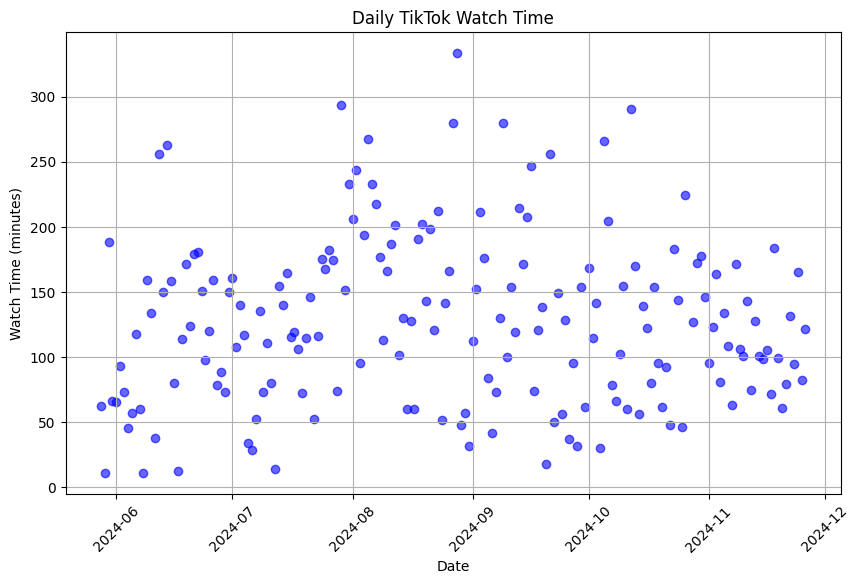

In [3]:
import matplotlib.pyplot as plt

# Scatter plot of daily watch time in minutes
plt.figure(figsize=(10, 6))
plt.scatter(daily_watch_time['day'], daily_watch_time['watch_time_minutes'], color='blue', alpha=0.6)
plt.title('Daily TikTok Watch Time')
plt.xlabel('Date')
plt.ylabel('Watch Time (minutes)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

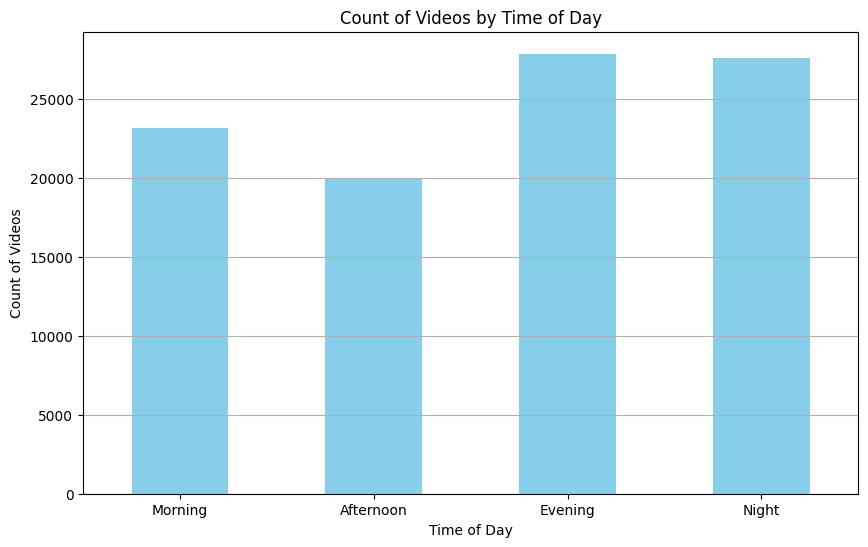

In [4]:
import matplotlib.pyplot as plt

# Define a function to categorize the time of day
def categorize_time_of_day(hour):
    if 5 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 17:
        return 'Afternoon'
    elif 17 <= hour < 21:
        return 'Evening'
    else:
        return 'Night'

# Apply the function to the 'Date' column to create a new 'time_of_day' column
video_df['time_of_day'] = video_df['Date'].dt.hour.apply(categorize_time_of_day)

# Set the order of categories
time_of_day_order = ['Morning', 'Afternoon', 'Evening', 'Night']
video_df['time_of_day'] = pd.Categorical(video_df['time_of_day'], categories=time_of_day_order, ordered=True)

# Group by 'time_of_day' and get the count of videos in each category
time_of_day_counts = video_df['time_of_day'].value_counts().sort_index()

# Plot the results
plt.figure(figsize=(10, 6))
time_of_day_counts.plot(kind='bar', color='skyblue')
plt.title('Count of Videos by Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Count of Videos')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

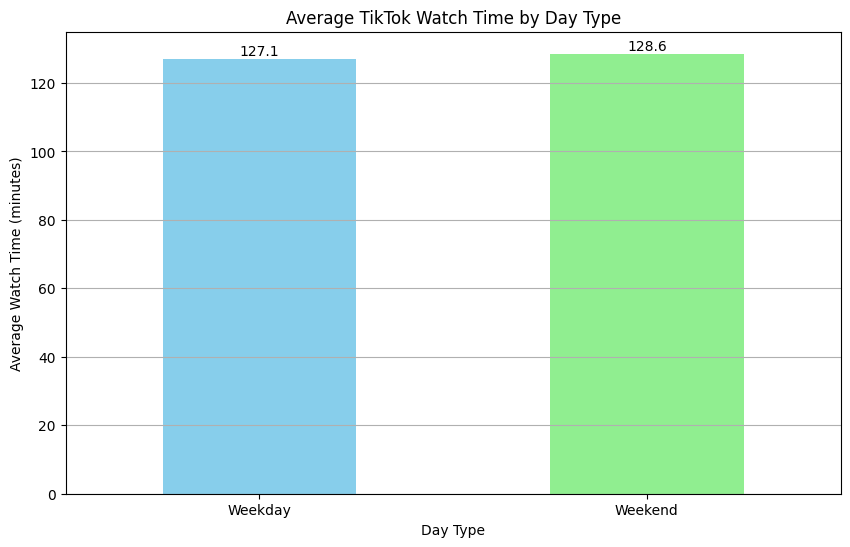

In [5]:
# Step 1: Create a new column 'day_type' to categorize the dates as weekends or weekdays
daily_watch_time['day_type'] = pd.to_datetime(daily_watch_time['day']).dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Step 2: Plot the watch time based on day type
plt.figure(figsize=(10, 6))
avg_by_day_type = daily_watch_time.groupby('day_type')['watch_time_minutes'].mean()
avg_by_day_type.plot(kind='bar', color=['skyblue', 'lightgreen'])
plt.title('Average TikTok Watch Time by Day Type')
plt.xlabel('Day Type')
plt.ylabel('Average Watch Time (minutes)')
plt.xticks(rotation=0)
plt.grid(axis='y')

# Add value labels on top of each bar
for i, v in enumerate(avg_by_day_type):
	plt.text(i, v + 1, f'{v:.1f}', ha='center')

plt.show()




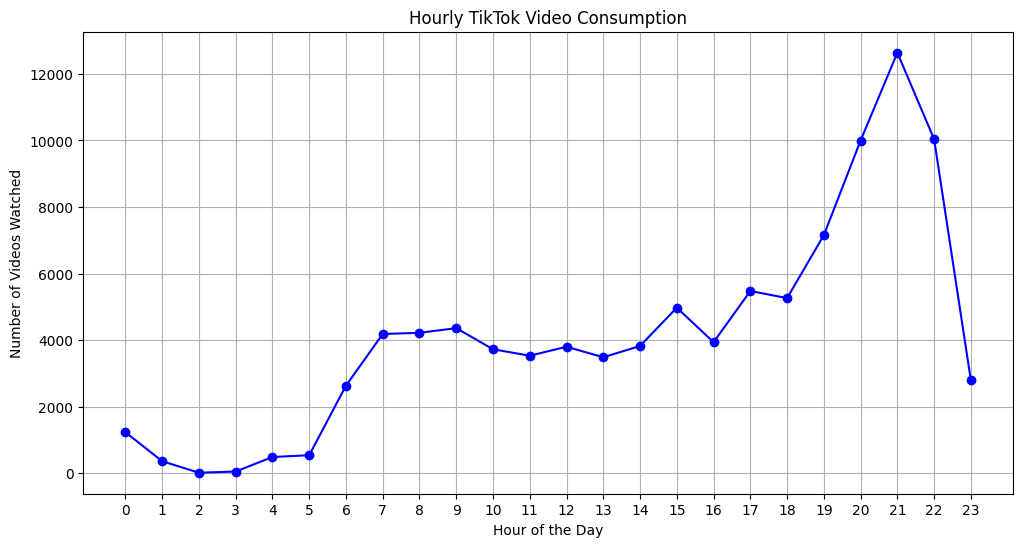

In [6]:
# Extract the hour from the 'Date' column
video_df['hour'] = video_df['Date'].dt.hour

# Group by hour and count the number of videos watched in each hour
hourly_usage = video_df.groupby('hour').size().reset_index(name='video_count')

# Plot the hourly usage
plt.figure(figsize=(12, 6))
plt.plot(hourly_usage['hour'], hourly_usage['video_count'], marker='o', linestyle='-', color='b')
plt.title('Hourly TikTok Video Consumption')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Videos Watched')
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()

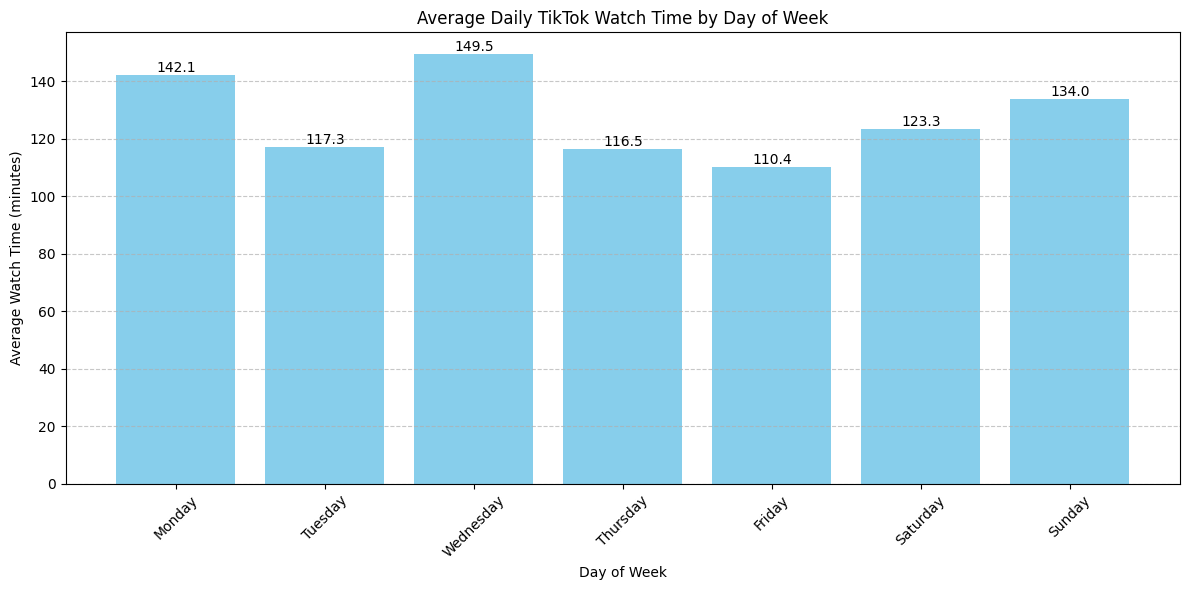

In [7]:
# Create a new column for day of week
daily_watch_time['day_of_week'] = pd.to_datetime(daily_watch_time['day']).dt.day_name()

# Calculate average watch time for each day of the week
weekly_avg = daily_watch_time.groupby('day_of_week')['watch_time_minutes'].mean()

# Reorder days of week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_avg = weekly_avg.reindex(day_order)

# Create the plot
plt.figure(figsize=(12, 6))
bar_plot = plt.bar(weekly_avg.index, weekly_avg.values, color='skyblue')
plt.title('Average Daily TikTok Watch Time by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Watch Time (minutes)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of each bar
for i, v in enumerate(weekly_avg.values):
    plt.text(i, v + 1, f'{v:.1f}', ha='center')

plt.tight_layout()
plt.show()

**HEALTH DATA ANALYSIS**

In [8]:

import pandas as pd
import xml.etree.ElementTree as ET

# Parse XML and extract all records
def parse_health_xml_to_df(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Extract all <Record> elements into a list of dictionaries
    records = [record.attrib for record in root.findall("Record")]

    # Convert to DataFrame
    return pd.DataFrame(records)

# Path to your XML file
health_file = "../apple_health_export.xml"
health_df = parse_health_xml_to_df(health_file)

# Explore the DataFrame
print(health_df.info())  # Check column names and data types
print(health_df.head())  # Preview the first few rows

# Filter for step count records and convert value column to numeric
steps_df = health_df[health_df['type'] == 'HKQuantityTypeIdentifierStepCount'].copy()
steps_df['value'] = pd.to_numeric(steps_df['value'])

# Convert dates to datetime
steps_df['startDate'] = pd.to_datetime(steps_df['startDate'])

# Group by date and sum steps
daily_steps = steps_df.groupby(steps_df['startDate'].dt.date)['value'].sum().reset_index()
daily_steps.columns = ['Date', 'Steps']

# Display results
print("\nDaily Step Counts:")
print(daily_steps.sort_values('Date', ascending=False).head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390834 entries, 0 to 390833
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   type           390834 non-null  object
 1   sourceName     390834 non-null  object
 2   sourceVersion  390675 non-null  object
 3   unit           390661 non-null  object
 4   creationDate   390834 non-null  object
 5   startDate      390834 non-null  object
 6   endDate        390834 non-null  object
 7   value          390834 non-null  object
 8   device         390807 non-null  object
dtypes: object(9)
memory usage: 26.8+ MB
None
                                type     sourceName sourceVersion   unit  \
0     HKQuantityTypeIdentifierHeight         Sağlık          11.4     cm   
1     HKQuantityTypeIdentifierHeight         Sağlık        13.5.1     cm   
2   HKQuantityTypeIdentifierBodyMass         Sağlık          13.1     kg   
3  HKQuantityTypeIdentifierStepCount  Sıla iPhone’u     

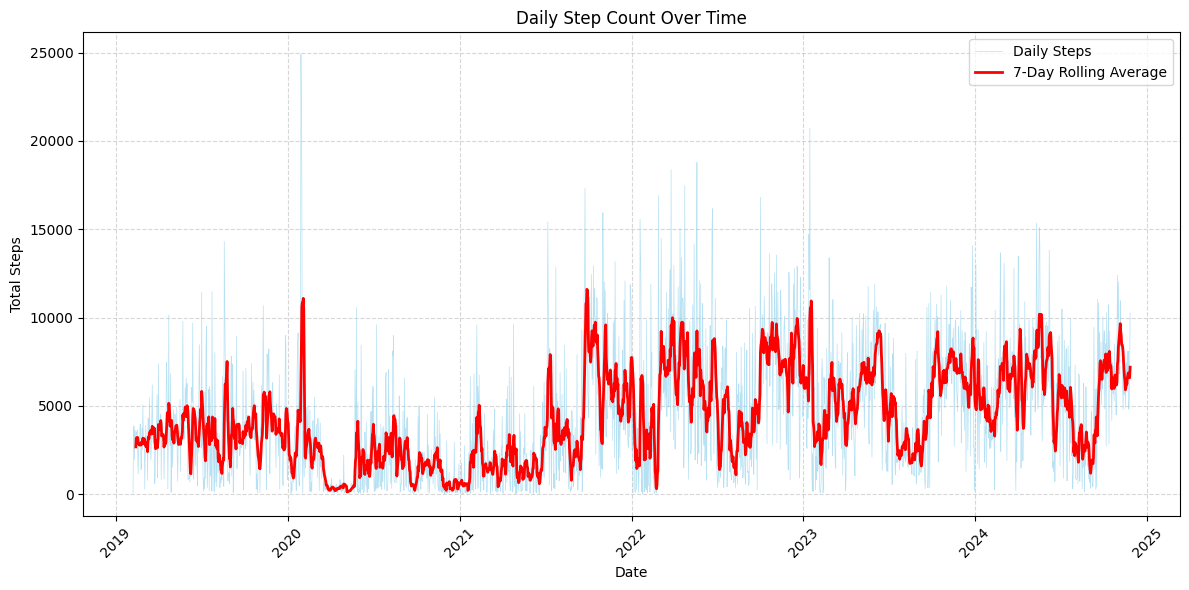

In [9]:
import matplotlib.pyplot as plt

# Smooth the data using a 7-day rolling average
daily_steps['rolling_avg'] = daily_steps['Steps'].rolling(window=7).mean()

plt.figure(figsize=(12, 6))

# Plot original data with reduced alpha for visibility
plt.plot(daily_steps['Date'], daily_steps['Steps'], color='skyblue', alpha=0.6, linewidth=0.5, label='Daily Steps')

# Plot the rolling average for a smoother trend line
plt.plot(daily_steps['Date'], daily_steps['rolling_avg'], color='red', linewidth=2, label='7-Day Rolling Average')

# Customize the x-axis date formatting
plt.title("Daily Step Count Over Time")
plt.xlabel("Date")
plt.ylabel("Total Steps")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()

# Format x-axis dates for better readability
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

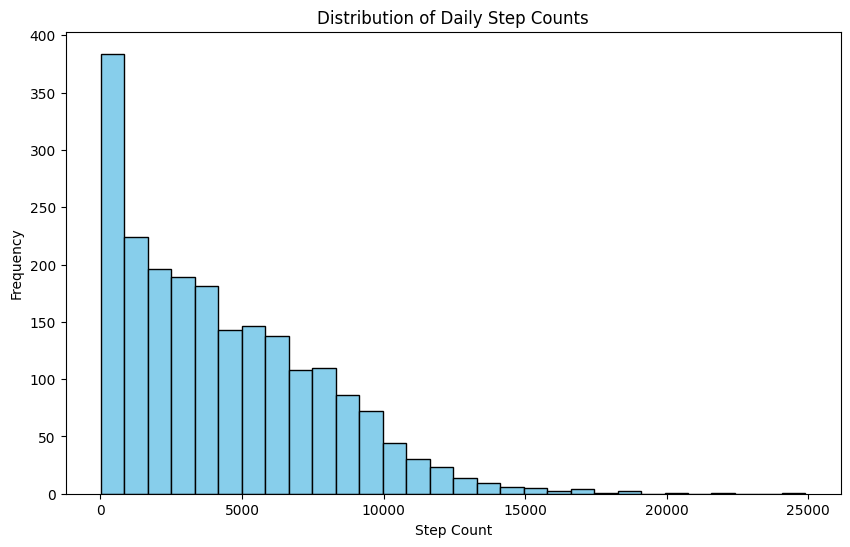

In [10]:
plt.figure(figsize=(10, 6))
plt.hist(daily_steps['Steps'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Daily Step Counts")
plt.xlabel("Step Count")
plt.ylabel("Frequency")
plt.show()

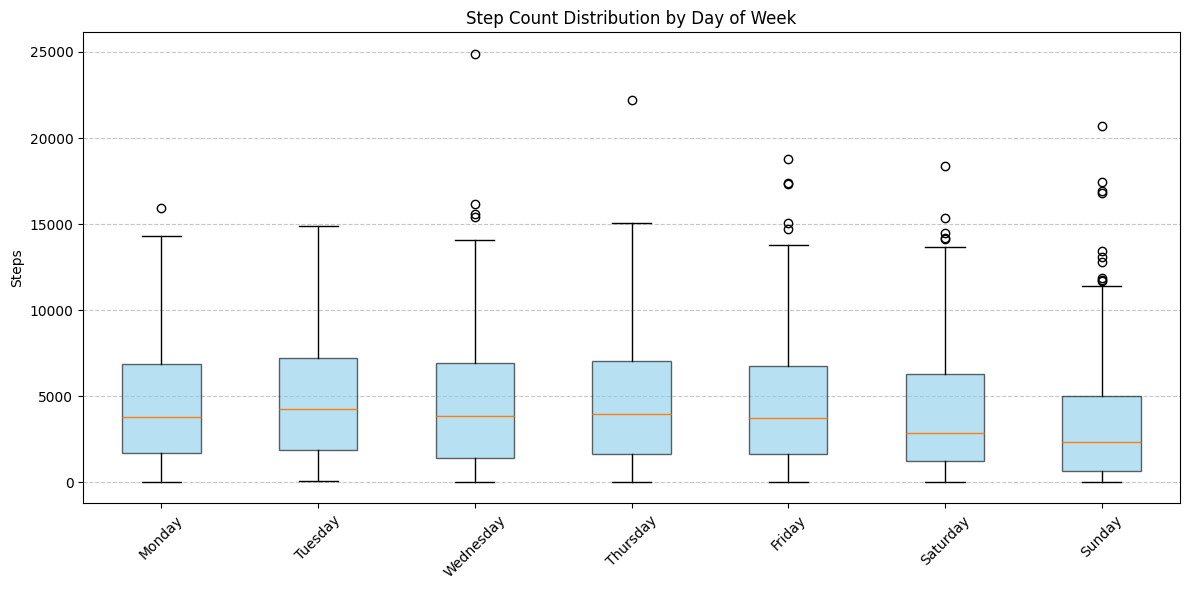


Average steps by day of week:
Monday: 4420 steps
Tuesday: 4725 steps
Wednesday: 4547 steps
Thursday: 4578 steps
Friday: 4534 steps
Saturday: 4040 steps
Sunday: 3417 steps


In [11]:
# Add day of week column
daily_steps['Day_of_Week'] = pd.to_datetime(daily_steps['Date']).dt.day_name()

# Set the order of days
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create box plot
plt.figure(figsize=(12, 6))
box_plot = plt.boxplot([daily_steps[daily_steps['Day_of_Week'] == day]['Steps'] for day in day_order],
                       labels=day_order,
                       patch_artist=True)

# Customize colors
for box in box_plot['boxes']:
    box.set(facecolor='skyblue', alpha=0.6)

plt.title('Step Count Distribution by Day of Week')
plt.ylabel('Steps')
plt.grid(True, axis='y', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Calculate and print average steps for each day
average_steps = daily_steps.groupby('Day_of_Week')['Steps'].mean().reindex(day_order)
print("\nAverage steps by day of week:")
for day, steps in average_steps.items():
    print(f"{day}: {steps:.0f} steps")

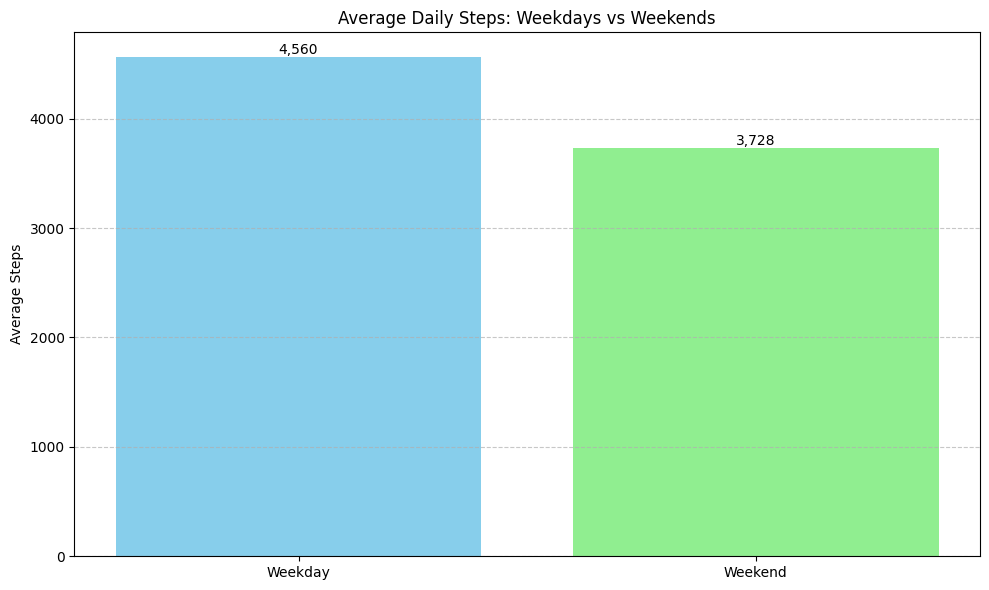


Average steps by day type:
Weekday: 4,560 steps
Weekend: 3,728 steps


In [12]:
# Create weekday/weekend classification
daily_steps['is_weekend'] = pd.to_datetime(daily_steps['Date']).dt.dayofweek.apply(lambda x: 'Weekend' if x >= 5 else 'Weekday')

# Calculate average steps for weekdays and weekends
avg_by_type = daily_steps.groupby('is_weekend')['Steps'].mean()

# Create bar plot
plt.figure(figsize=(10, 6))
colors = ['skyblue', 'lightgreen']
bars = plt.bar(avg_by_type.index, avg_by_type.values, color=colors)
plt.title('Average Daily Steps: Weekdays vs Weekends')
plt.ylabel('Average Steps')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Print the actual values
print("\nAverage steps by day type:")
for day_type, steps in avg_by_type.items():
    print(f"{day_type}: {int(steps):,} steps")

Top 5 High Activity Days:
            Date  Steps Day_of_Week
356   2020-01-29  24898   Wednesday
357   2020-01-30  22183    Thursday
1438  2023-01-15  20708      Sunday
1198  2022-05-20  18782      Friday
1143  2022-03-26  18376    Saturday

Top 5 Low Activity Days:
            Date  Steps Day_of_Week
701   2021-01-08     18      Friday
1107  2022-02-18     26      Friday
596   2020-09-25     29      Friday
1082  2022-01-24     31      Monday
661   2020-11-29     32      Sunday


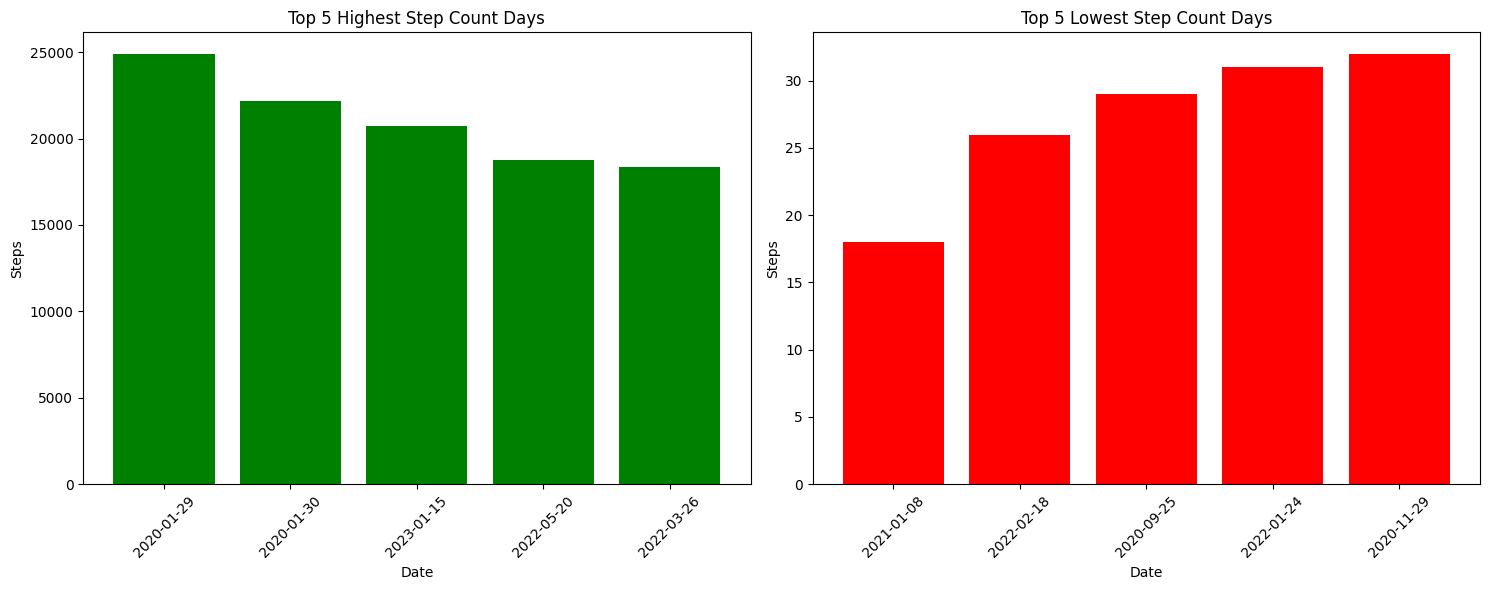

In [13]:
high_activity_days = daily_steps.nlargest(5, 'Steps')
low_activity_days = daily_steps.nsmallest(5, 'Steps')

print("Top 5 High Activity Days:")
print(high_activity_days[['Date', 'Steps', 'Day_of_Week']])

print("\nTop 5 Low Activity Days:")
print(low_activity_days[['Date', 'Steps', 'Day_of_Week']])

# Create a figure with two subplots side by side
plt.figure(figsize=(15, 6))

# First subplot - High Activity Days
plt.subplot(1, 2, 1)
plt.bar(high_activity_days['Date'].astype(str), high_activity_days['Steps'], color='green')
plt.title('Top 5 Highest Step Count Days')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)

# Second subplot - Low Activity Days
plt.subplot(1, 2, 2)
plt.bar(low_activity_days['Date'].astype(str), low_activity_days['Steps'], color='red')
plt.title('Top 5 Lowest Step Count Days')
plt.xlabel('Date')
plt.ylabel('Steps')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

**COMBINATION OF HEALTH AND TIKTOK DATA**

In [18]:
import pandas as pd

# Debug Step: Print column names to check their structure
print("daily_steps columns:", daily_steps.columns)
print("daily_watch_time columns:", daily_watch_time.columns)

# Step 1: Clean column names to avoid invisible spaces
daily_steps.columns = daily_steps.columns.str.strip()
daily_watch_time.columns = daily_watch_time.columns.str.strip()

# Step 2: Rename 'day' to 'Date' in daily_watch_time
if 'day' in daily_watch_time.columns:
    daily_watch_time = daily_watch_time.rename(columns={'day': 'Date'})

# Step 3: Ensure 'Date' columns exist and are in datetime format
daily_steps['Date'] = pd.to_datetime(daily_steps['Date'])
daily_watch_time['Date'] = pd.to_datetime(daily_watch_time['Date'])

# Step 4: Filter daily_steps to match the range of TikTok watch time data
tiktok_start_date = daily_watch_time['Date'].min()
tiktok_end_date = daily_watch_time['Date'].max()

filtered_steps = daily_steps[
    (daily_steps['Date'] >= tiktok_start_date) & 
    (daily_steps['Date'] <= tiktok_end_date)
]

# Step 5: Merge both DataFrames on 'Date'
combined_df = pd.merge(filtered_steps, daily_watch_time, on='Date', how='outer')

# Step 6: Fill missing values with 0 for consistency
combined_df['Steps'] = combined_df['Steps'].fillna(0)
combined_df['watch_time_minutes'] = combined_df['watch_time_minutes'].fillna(0)

# Step 7: Display the merged DataFrame
print("Combined DataFrame:")
print(combined_df.head())

# Optional: Save the combined DataFrame for further use
combined_df.to_csv("combined_steps_watchtime.csv", index=False)

# Step 8: Verify data ranges
print(f"Combined data from: {combined_df['Date'].min()} to {combined_df['Date'].max()}")

daily_steps columns: Index(['Date', 'Steps', 'rolling_avg', 'Day_of_Week', 'is_weekend'], dtype='object')
daily_watch_time columns: Index(['day', 'time_diff_seconds', 'watch_time_minutes', 'day_type',
       'day_of_week'],
      dtype='object')
Combined DataFrame:
        Date  Steps  rolling_avg Day_of_Week is_weekend  time_diff_seconds  \
0 2024-05-28   5395  5640.142857     Tuesday    Weekday             3751.0   
1 2024-05-29   8312  6092.571429   Wednesday    Weekday              657.0   
2 2024-05-30   9567  7030.000000    Thursday    Weekday            11308.0   
3 2024-05-31   6289  7209.714286      Friday    Weekday             3956.0   
4 2024-06-01   9731  7511.000000    Saturday    Weekend             3945.0   

   watch_time_minutes day_type day_of_week  
0           62.516667  Weekday     Tuesday  
1           10.950000  Weekday   Wednesday  
2          188.466667  Weekday    Thursday  
3           65.933333  Weekday      Friday  
4           65.750000  Weekend    Saturd

Correlation between Steps and TikTok Watch Time: -0.32


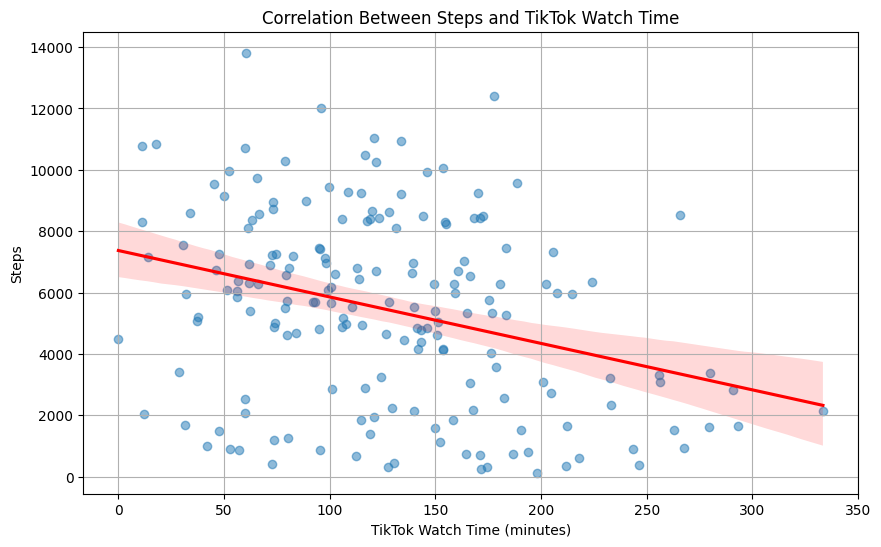

In [19]:
# Calculate correlation
correlation = combined_df['Steps'].corr(combined_df['watch_time_minutes'])
print(f"Correlation between Steps and TikTok Watch Time: {correlation:.2f}")

# Scatter plot with regression line
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.regplot(x='watch_time_minutes', y='Steps', data=combined_df, scatter_kws={'alpha':0.5}, line_kws={"color": "red"})
plt.title('Correlation Between Steps and TikTok Watch Time')
plt.xlabel('TikTok Watch Time (minutes)')
plt.ylabel('Steps')
plt.grid()
plt.show()

<Figure size 1200x600 with 0 Axes>

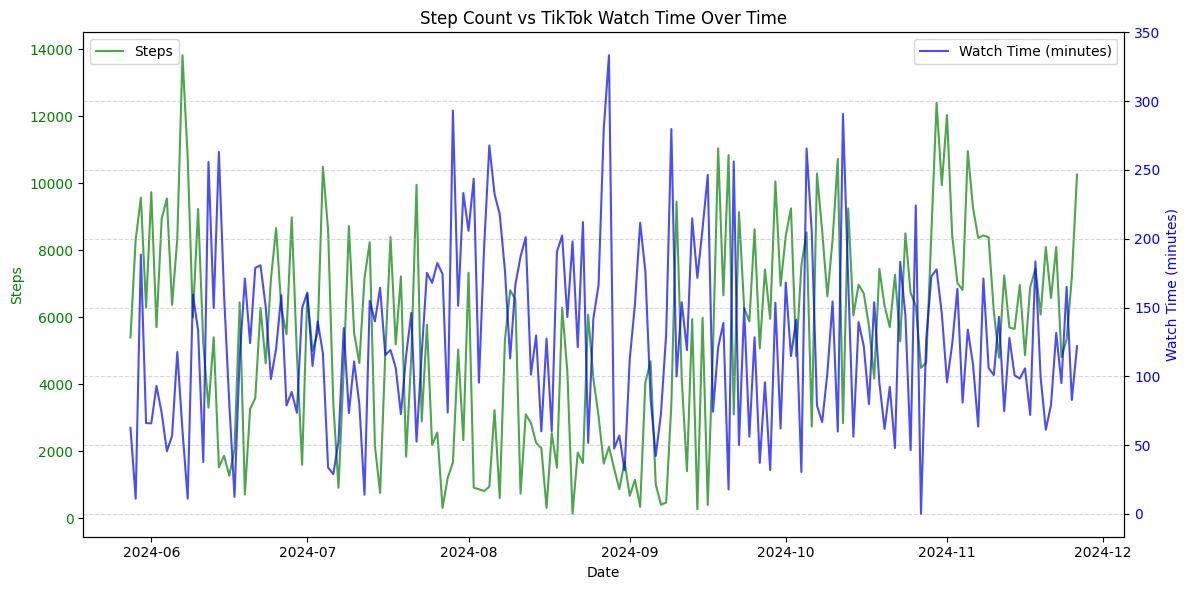

In [20]:
plt.figure(figsize=(12, 6))

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Steps on the primary y-axis
ax1.plot(combined_df['Date'], combined_df['Steps'], color='green', alpha=0.7, label='Steps')
ax1.set_xlabel('Date')
ax1.set_ylabel('Steps', color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary y-axis for Watch Time
ax2 = ax1.twinx()
ax2.plot(combined_df['Date'], combined_df['watch_time_minutes'], color='blue', alpha=0.7, label='Watch Time (minutes)')
ax2.set_ylabel('Watch Time (minutes)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Add grid, titles, and legend
plt.title("Step Count vs TikTok Watch Time Over Time")
fig.tight_layout()
plt.grid(visible=True, linestyle='--', alpha=0.5)

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

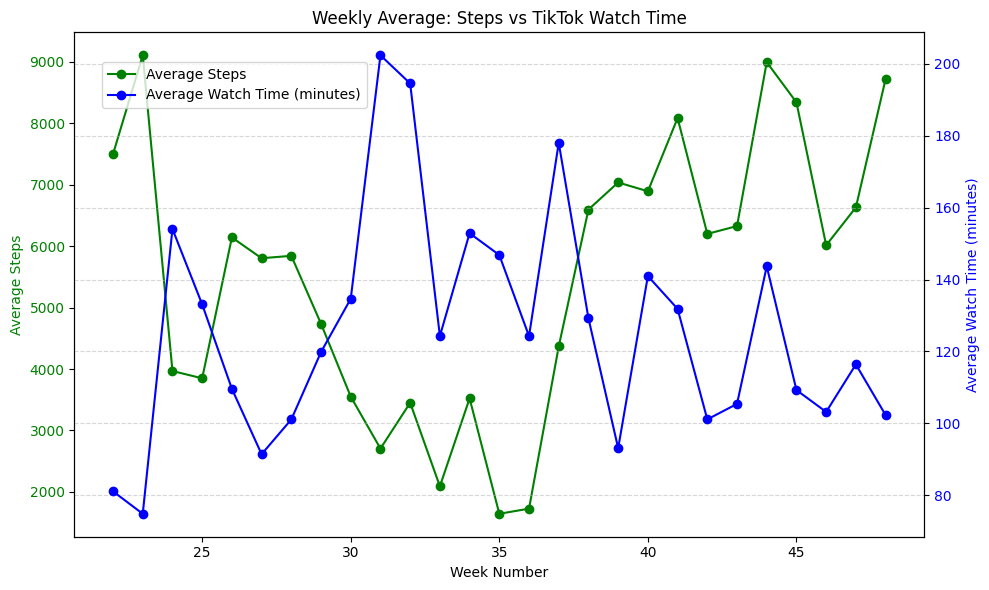

In [22]:
# Add a 'week' column
combined_df['week'] = combined_df['Date'].dt.isocalendar().week

# Group by week and calculate averages
weekly_data = combined_df.groupby('week')[['Steps', 'watch_time_minutes']].mean().reset_index()

# Plot weekly trends with dual axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot Steps on the left y-axis
ax1.plot(weekly_data['week'], weekly_data['Steps'], label='Average Steps', color='green', marker='o')
ax1.set_xlabel("Week Number")
ax1.set_ylabel("Average Steps", color='green')
ax1.tick_params(axis='y', labelcolor='green')

# Create a secondary y-axis for Watch Time
ax2 = ax1.twinx()
ax2.plot(weekly_data['week'], weekly_data['watch_time_minutes'], label='Average Watch Time (minutes)', color='blue', marker='o')
ax2.set_ylabel("Average Watch Time (minutes)", color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Title and grid
plt.title("Weekly Average: Steps vs TikTok Watch Time")
fig.tight_layout()
fig.legend(loc="upper left", bbox_to_anchor=(0.1, 0.9))

plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [23]:
correlation = combined_df['Steps'].corr(combined_df['watch_time_minutes'])
print(f"Correlation between Steps and TikTok Watch Time: {correlation:.2f}")

Correlation between Steps and TikTok Watch Time: -0.32
